<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/day4_weather_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Weather Predictor - Day 4 Project





futuristic-weather-prediction-flowchart.svg

# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

print("Setup Complete!")


Setup Complete!


#Data Collection

# Let's use **Open-Meteo API** to get historical weather data
# This is a free weather API that provides historical data

In [ ]:
def get_weather_data(latitude, longitude, start_date, end_date):
    """
    Fetch historical weather data from Open-Meteo API

    Parameters:
    latitude (float): Location latitude
    longitude (float): Location longitude
    start_date (str): Start date in format YYYY-MM-DD
    end_date (str): End date in format YYYY-MM-DD

    Returns:
    pandas DataFrame with daily weather data
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'daily': 'temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration',
        'timezone': 'auto'
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame({
            'date': pd.to_datetime(data['daily']['time']),
            'temp_max': data['daily']['temperature_2m_max'],
            'temp_min': data['daily']['temperature_2m_min'],
            'temp_mean': data['daily']['temperature_2m_mean'],
            'apparent_temp_max': data['daily']['apparent_temperature_max'],
            'apparent_temp_min': data['daily']['apparent_temperature_min'],
            'precipitation': data['daily']['precipitation_sum'],
            'rain': data['daily']['rain_sum'],
            'snowfall': data['daily']['snowfall_sum'],
            'precipitation_hours': data['daily']['precipitation_hours'],
            'windspeed_max': data['daily']['windspeed_10m_max'],
            'windgusts_max': data['daily']['windgusts_10m_max'],
            'winddirection': data['daily']['winddirection_10m_dominant'],
            'radiation': data['daily']['shortwave_radiation_sum'],
            'evapotranspiration': data['daily']['et0_fao_evapotranspiration']
        })

        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        print(response.text)
        return None

**Let's get weather data for New York City for the past 2 years**

In [ ]:
# Let's get weather data for Toronto for the past 2 years
# Toronto coordinates
toronto_lat = 43.6532
toronto_lon = -79.3832

# Define date range (2 years)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')

# Fetch the data
print(f"Fetching weather data for Toronto from {start_date} to {end_date}...")
weather_data = get_weather_data(toronto_lat, toronto_lon, start_date, end_date)

Fetching weather data for Toronto from 2023-04-19 to 2025-04-18...


#Data Exploration and Preprocessing

In [ ]:
if weather_data is not None:
    # Display basic information
    print("\nData Overview:")
    print(f"Shape: {weather_data.shape}")
    print("\nFirst few rows:")
    print(weather_data.head())

    # Summary statistics
    print("\nSummary Statistics:")
    print(weather_data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(weather_data.isnull().sum())

    # Fill missing values if any
    weather_data = weather_data.fillna(method='ffill')

    # Set date as index
    weather_data = weather_data.set_index('date')


Data Overview:
Shape: (731, 15)

First few rows:
        date  temp_max  temp_min  temp_mean  apparent_temp_max  \
0 2023-04-19      10.9       1.5        5.4                7.4   
1 2023-04-20       7.8       3.9        5.9                3.1   
2 2023-04-21      20.0       5.5       10.8               19.8   
3 2023-04-22      12.1       7.4        9.6                9.7   
4 2023-04-23      10.1       3.7        7.0                6.0   

   apparent_temp_min  precipitation  rain  snowfall  precipitation_hours  \
0               -4.5            0.5   0.5       0.0                  1.0   
1               -0.0            0.3   0.3       0.0                  1.0   
2                1.8            9.9   9.9       0.0                  5.0   
3                5.3           19.0  19.0       0.0                 18.0   
4                0.3            0.9   0.9       0.0                  6.0   

   windspeed_max  windgusts_max  winddirection  radiation  evapotranspiration  
0           20.9

**Plot temperature data**

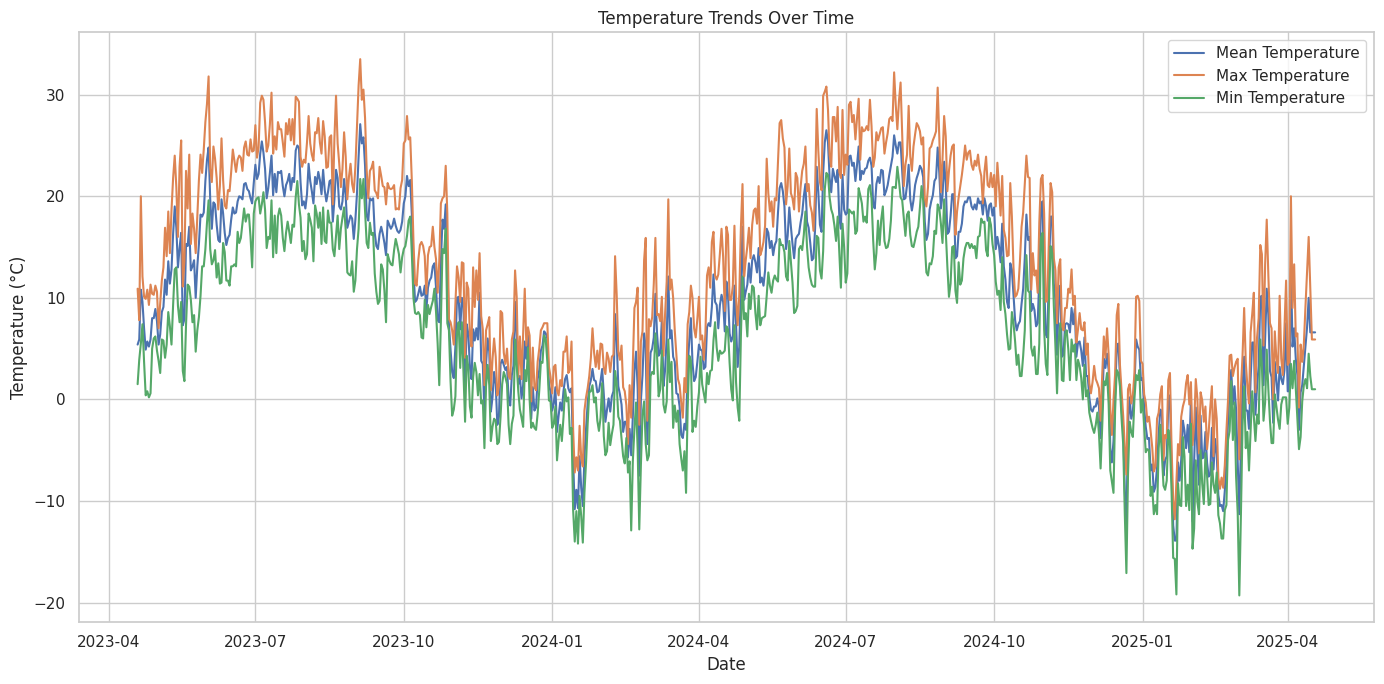

In [ ]:
    plt.figure(figsize=(14, 7))
    plt.plot(weather_data.index, weather_data['temp_mean'], label='Mean Temperature')
    plt.plot(weather_data.index, weather_data['temp_max'], label='Max Temperature')
    plt.plot(weather_data.index, weather_data['temp_min'], label='Min Temperature')
    plt.title('Temperature Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Plot precipitation data**

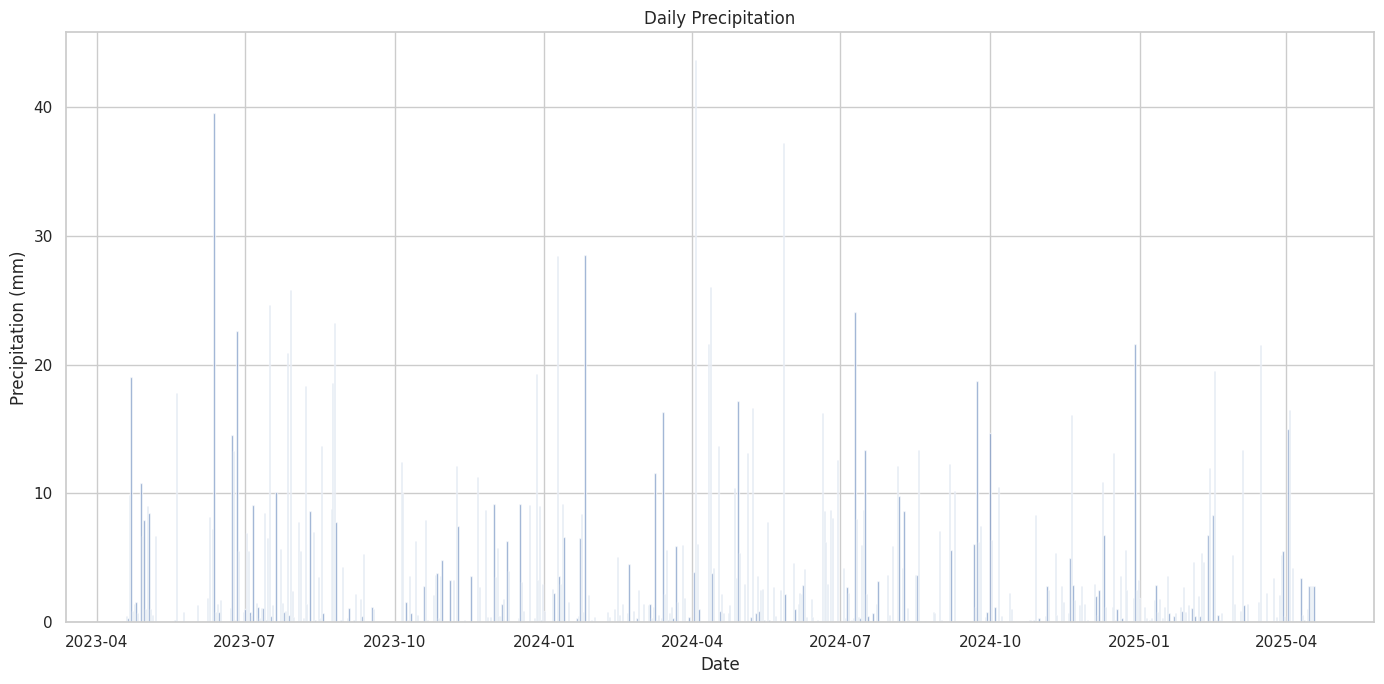

In [ ]:
    plt.figure(figsize=(14, 7))
    plt.bar(weather_data.index, weather_data['precipitation'], alpha=0.7)
    plt.title('Daily Precipitation')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.tight_layout()
    plt.show()


# Feature Engineering

In [ ]:
    # Create lag features for temperature
    for i in range(1, 8):  # Create lags for 1 to 7 days
        weather_data[f'temp_mean_lag_{i}'] = weather_data['temp_mean'].shift(i)
        weather_data[f'temp_max_lag_{i}'] = weather_data['temp_max'].shift(i)
        weather_data[f'temp_min_lag_{i}'] = weather_data['temp_min'].shift(i)
        weather_data[f'precipitation_lag_{i}'] = weather_data['precipitation'].shift(i)

    # Create rolling window features (moving averages)
    weather_data['temp_mean_rolling_3d'] = weather_data['temp_mean'].rolling(window=3).mean()
    weather_data['temp_mean_rolling_7d'] = weather_data['temp_mean'].rolling(window=7).mean()

    # Create day of year feature to capture seasonality
    weather_data['day_of_year'] = weather_data.index.dayofyear
    weather_data['month'] = weather_data.index.month

    # Create target variables (next day's weather)
    weather_data['next_day_temp_mean'] = weather_data['temp_mean'].shift(-1)
    weather_data['next_day_temp_max'] = weather_data['temp_max'].shift(-1)
    weather_data['next_day_temp_min'] = weather_data['temp_min'].shift(-1)
    weather_data['next_day_precipitation'] = weather_data['precipitation'].shift(-1)

    # Drop rows with missing values after creating lag features
    weather_data = weather_data.dropna()

    # Display the updated dataset
    print("\nProcessed Dataset with Engineered Features:")
    print(weather_data.head())


Processed Dataset with Engineered Features:
            temp_max  temp_min  temp_mean  apparent_temp_max  \
date                                                           
2023-04-26       9.3       0.2        5.2                7.7   
2023-04-27      11.3       0.6        5.9                9.3   
2023-04-28      10.4       5.0        8.0                7.5   
2023-04-29      10.3       6.0        8.0                8.1   
2023-04-30      11.2       6.2        8.9                9.8   

            apparent_temp_min  precipitation  rain  snowfall  \
date                                                           
2023-04-26               -3.7            0.7   0.7       0.0   
2023-04-27               -2.6            0.0   0.0       0.0   
2023-04-28                1.0           10.8  10.8       0.0   
2023-04-29                0.7            6.7   6.7       0.0   
2023-04-30                3.9            7.9   7.9       0.0   

            precipitation_hours  windspeed_max  ...  temp

# Model Training

In [ ]:
    # Define features and target for temperature prediction
    temp_features = [col for col in weather_data.columns if 'lag' in col or 'rolling' in col or col in ['day_of_year', 'month']]

    # Temperature prediction
    X = weather_data[temp_features]
    y_temp_mean = weather_data['next_day_temp_mean']
    y_temp_max = weather_data['next_day_temp_max']
    y_temp_min = weather_data['next_day_temp_min']
    y_precip = weather_data['next_day_precipitation']

    # Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_temp_mean_train, y_temp_mean_test = y_temp_mean[:train_size], y_temp_mean[train_size:]

    # Train a linear regression model for mean temperature
    print("\nTraining linear regression model for temperature prediction...")
    temp_model = LinearRegression()
    temp_model.fit(X_train, y_temp_mean_train)

    # Make predictions
    train_preds = temp_model.predict(X_train)
    test_preds = temp_model.predict(X_test)


Training linear regression model for temperature prediction...


#  Model Evaluation

In [ ]:
    # Calculate metrics
    train_mae = mean_absolute_error(y_temp_mean_train, train_preds)
    train_rmse = np.sqrt(mean_squared_error(y_temp_mean_train, train_preds))
    train_r2 = r2_score(y_temp_mean_train, train_preds)

    test_mae = mean_absolute_error(y_temp_mean_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_temp_mean_test, test_preds))
    test_r2 = r2_score(y_temp_mean_test, test_preds)

    print("\nModel Performance Metrics:")
    print(f"Training MAE: {train_mae:.2f}°C")
    print(f"Training RMSE: {train_rmse:.2f}°C")
    print(f"Training R²: {train_r2:.2f}")
    print(f"Test MAE: {test_mae:.2f}°C")
    print(f"Test RMSE: {test_rmse:.2f}°C")
    print(f"Test R²: {test_r2:.2f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': temp_features,
        'Coefficient': temp_model.coef_
    })
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance.head(10))


Model Performance Metrics:
Training MAE: 1.82°C
Training RMSE: 2.38°C
Training R²: 0.92
Test MAE: 2.99°C
Test RMSE: 3.72°C
Test R²: 0.54

Feature Importance:
                 Feature  Coefficient  Abs_Coefficient
28  temp_mean_rolling_3d     2.121847         2.121847
29  temp_mean_rolling_7d     1.052366         1.052366
0        temp_mean_lag_1    -0.950794         0.950794
4        temp_mean_lag_2    -0.874783         0.874783
16       temp_mean_lag_5     0.725863         0.725863
17        temp_max_lag_5    -0.491255         0.491255
18        temp_min_lag_5    -0.397750         0.397750
12       temp_mean_lag_4     0.322752         0.322752
31                 month    -0.306665         0.306665
13        temp_max_lag_4    -0.236351         0.236351


 # Visualization of Predictions

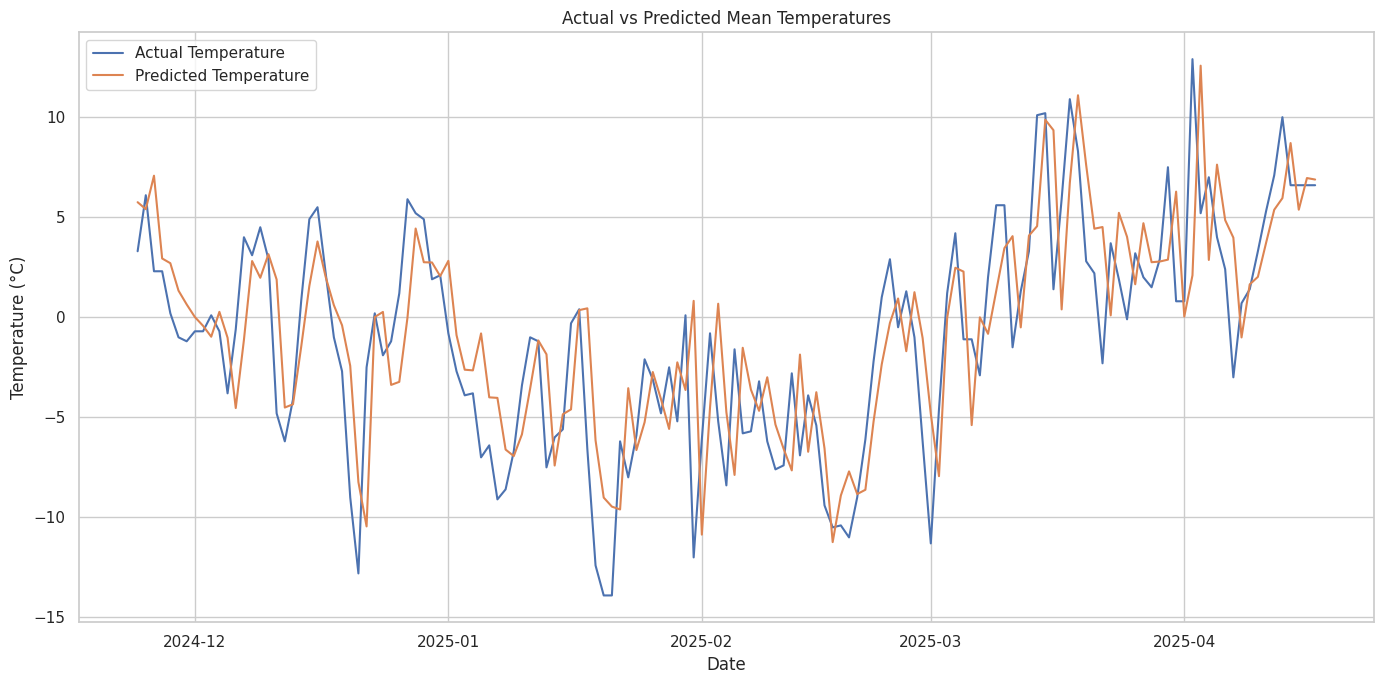

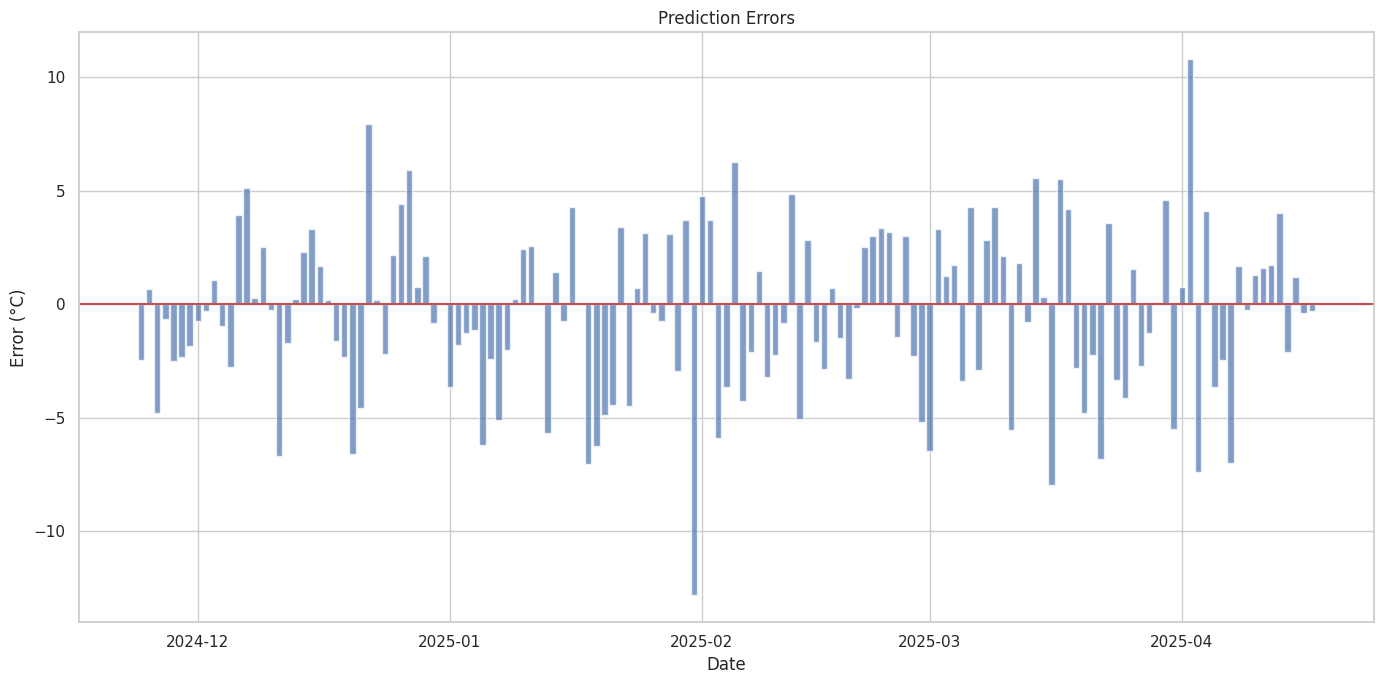

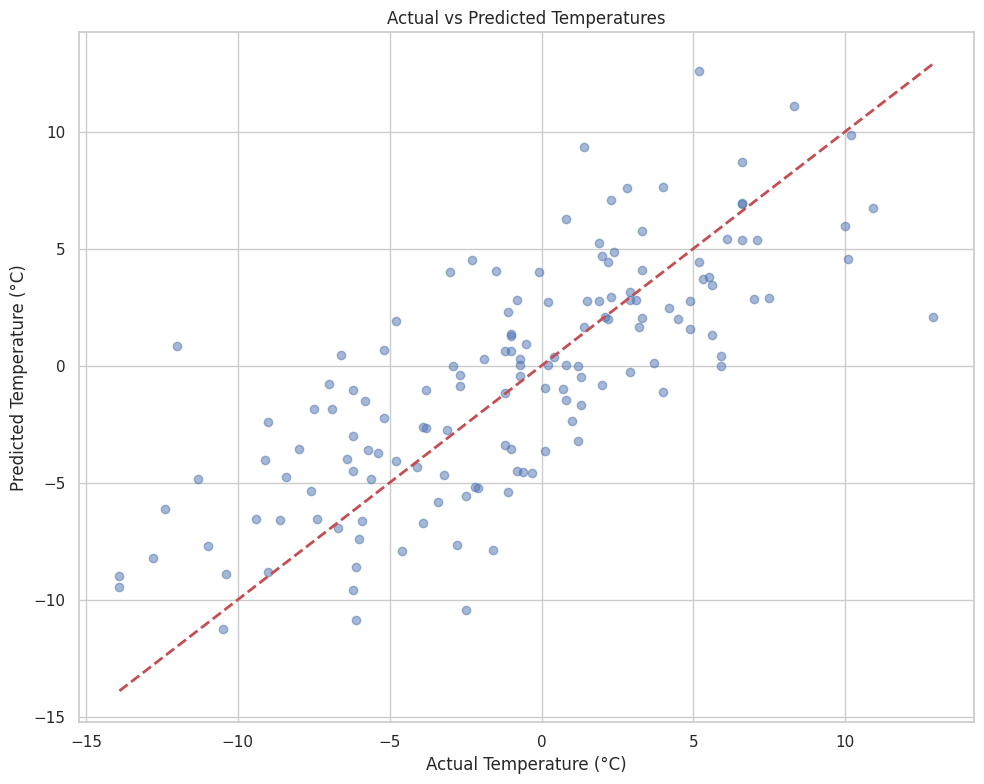

In [ ]:
    # Create a dataframe with actual and predicted temperatures
    results_df = pd.DataFrame({
        'Actual': y_temp_mean_test,
        'Predicted': test_preds
    })

    # Plot actual vs predicted temperatures
    plt.figure(figsize=(14, 7))
    plt.plot(results_df.index, results_df['Actual'], label='Actual Temperature')
    plt.plot(results_df.index, results_df['Predicted'], label='Predicted Temperature')
    plt.title('Actual vs Predicted Mean Temperatures')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot prediction errors
    results_df['Error'] = results_df['Actual'] - results_df['Predicted']

    plt.figure(figsize=(14, 7))
    plt.bar(results_df.index, results_df['Error'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Prediction Errors')
    plt.xlabel('Date')
    plt.ylabel('Error (°C)')
    plt.tight_layout()
    plt.show()

    # Scatter plot of actual vs predicted temperatures
    plt.figure(figsize=(10, 8))
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
             [results_df['Actual'].min(), results_df['Actual'].max()],
             'r--', lw=2)
    plt.title('Actual vs Predicted Temperatures')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.tight_layout()
    plt.show()

 # Advanced Model - Random Forest


Training Random Forest model for temperature prediction...

Random Forest Model Performance Metrics:
Training MAE: 0.83°C
Training RMSE: 1.09°C
Training R²: 0.98
Test MAE: 3.66°C
Test RMSE: 4.64°C
Test R²: 0.29

Model Comparison:
  Metric  Linear Regression  Random Forest
0    MAE           2.989987       3.655876
1   RMSE           3.722974       4.638047
2     R²           0.543926       0.292176

Random Forest Feature Importance:
                 Feature  Importance
28  temp_mean_rolling_3d    0.604014
29  temp_mean_rolling_7d    0.190867
0        temp_mean_lag_1    0.066453
30           day_of_year    0.023760
26        temp_min_lag_7    0.011774
1         temp_max_lag_1    0.010489
3    precipitation_lag_1    0.007607
6         temp_min_lag_2    0.006826
2         temp_min_lag_1    0.005574
4        temp_mean_lag_2    0.004375


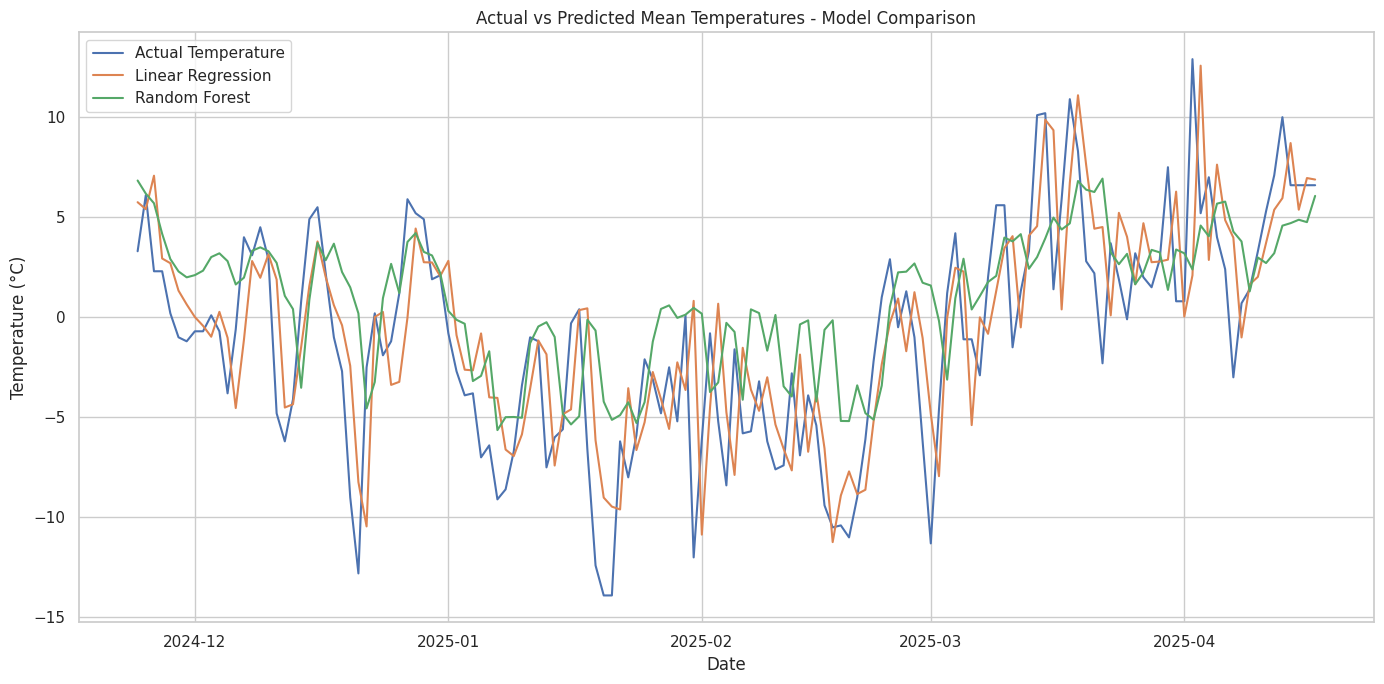

In [ ]:
    print("\nTraining Random Forest model for temperature prediction...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_temp_mean_train)

    # Make predictions with Random Forest
    rf_train_preds = rf_model.predict(X_train)
    rf_test_preds = rf_model.predict(X_test)

    # Calculate metrics for Random Forest
    rf_train_mae = mean_absolute_error(y_temp_mean_train, rf_train_preds)
    rf_train_rmse = np.sqrt(mean_squared_error(y_temp_mean_train, rf_train_preds))
    rf_train_r2 = r2_score(y_temp_mean_train, rf_train_preds)

    rf_test_mae = mean_absolute_error(y_temp_mean_test, rf_test_preds)
    rf_test_rmse = np.sqrt(mean_squared_error(y_temp_mean_test, rf_test_preds))
    rf_test_r2 = r2_score(y_temp_mean_test, rf_test_preds)

    print("\nRandom Forest Model Performance Metrics:")
    print(f"Training MAE: {rf_train_mae:.2f}°C")
    print(f"Training RMSE: {rf_train_rmse:.2f}°C")
    print(f"Training R²: {rf_train_r2:.2f}")
    print(f"Test MAE: {rf_test_mae:.2f}°C")
    print(f"Test RMSE: {rf_test_rmse:.2f}°C")
    print(f"Test R²: {rf_test_r2:.2f}")

    # Compare performance of Linear Regression vs Random Forest
    print("\nModel Comparison:")
    comparison_df = pd.DataFrame({
        'Metric': ['MAE', 'RMSE', 'R²'],
        'Linear Regression': [test_mae, test_rmse, test_r2],
        'Random Forest': [rf_test_mae, rf_test_rmse, rf_test_r2]
    })
    print(comparison_df)

    # Feature importance from Random Forest
    rf_feature_importance = pd.DataFrame({
        'Feature': temp_features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nRandom Forest Feature Importance:")
    print(rf_feature_importance.head(10))

    # Visualize Random Forest predictions
    results_df['RF_Predicted'] = rf_test_preds

    plt.figure(figsize=(14, 7))
    plt.plot(results_df.index, results_df['Actual'], label='Actual Temperature')
    plt.plot(results_df.index, results_df['Predicted'], label='Linear Regression')
    plt.plot(results_df.index, results_df['RF_Predicted'], label='Random Forest')
    plt.title('Actual vs Predicted Mean Temperatures - Model Comparison')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.tight_layout()
    plt.show()

 #  Make a prediction for the next day

In [ ]:
# ... (Your existing code for data collection and processing)

if weather_data is not None:
    # ... (Your existing code for data exploration, feature engineering, model training, etc.)

    # STEP 8: Make a prediction for the next day
    try:
        last_row = weather_data.iloc[-1:]
        last_features = last_row[temp_features]

        # Predict using both models
        lr_next_day = temp_model.predict(last_features)[0]
        rf_next_day = rf_model.predict(last_features)[0]

        print("\nNext Day Temperature Prediction:")
        print(f"Date: {(last_row.index[0] + pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"Linear Regression Prediction: {lr_next_day:.2f}°C")
        print(f"Random Forest Prediction: {rf_next_day:.2f}°C")
        print(f"Ensemble Prediction (Average): {(lr_next_day + rf_next_day) / 2:.2f}°C")

        # Compare with today's temperature
        print(f"Today's temperature: {last_row['temp_mean'].values[0]:.2f}°C")

    except Exception as e:  # Aligned with the 'try' block
        print(f"\nCouldn't make next day prediction: {e}")

else:
    print("Failed to retrieve weather data. Please check your internet connection and try again.")

print("\nWeather Predictor project completed successfully!")


Next Day Temperature Prediction:
Date: 2025-04-18
Linear Regression Prediction: 6.88°C
Random Forest Prediction: 6.07°C
Ensemble Prediction (Average): 6.47°C
Today's temperature: 6.60°C

Weather Predictor project completed successfully!
